In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df1=pd.read_csv('freMTPLfreq.csv')
df2=pd.read_csv('freMTPLsev.csv')
# Print shape of dataset


In [2]:
df3 = df2.groupby(['PolicyID'])[['ClaimAmount']].agg('sum').reset_index()
df_merged = pd.merge(df1, df3, how='outer', on='PolicyID').fillna(0)

In [3]:
df_merged.isnull().sum()

PolicyID       0
ClaimNb        0
Exposure       0
Power          0
CarAge         0
DriverAge      0
Brand          0
Gas            0
Region         0
Density        0
ClaimAmount    0
dtype: int64

In [4]:
df_merged['ClaimFreq'] = df_merged['ClaimNb'] / df_merged['Exposure']

In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413169 entries, 0 to 413168
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PolicyID     413169 non-null  int64  
 1   ClaimNb      413169 non-null  int64  
 2   Exposure     413169 non-null  float64
 3   Power        413169 non-null  object 
 4   CarAge       413169 non-null  int64  
 5   DriverAge    413169 non-null  int64  
 6   Brand        413169 non-null  object 
 7   Gas          413169 non-null  object 
 8   Region       413169 non-null  object 
 9   Density      413169 non-null  int64  
 10  ClaimAmount  413169 non-null  float64
 11  ClaimFreq    413169 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 37.8+ MB


In [6]:
df_merged=df_merged.drop(columns=['PolicyID'],axis=1)

In [7]:
# Numeric Features

num_features = [feature for feature in df_merged.columns if df_merged[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

#Categorical Features

cat_features = [feature for feature in df_merged.columns if df_merged[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

#Discrete features

discrete_features=[feature for feature in num_features if len(df_merged[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

#Continues Features

continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Numerical Features : 7
Num of Categorical Features : 4
Num of Discrete Features : 1
Num of Continuous Features : 6


In [8]:
# Split X and Y
X = df_merged.drop('ClaimAmount', axis=1)
y = df_merged['ClaimAmount']

In [9]:
type(X),type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [10]:
continuous_features

['Exposure', 'CarAge', 'DriverAge', 'Density', 'ClaimAmount', 'ClaimFreq']

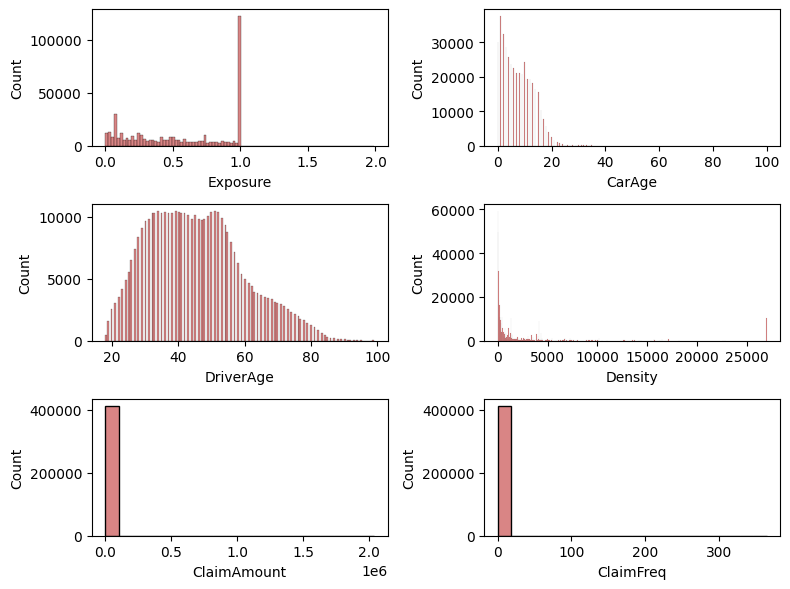

In [11]:
# distribution of data before scaling
import math
plt.figure(figsize=(8, 6))
# Calculate number of rows and columns required
con_features = len(continuous_features)
num_cols = 2  # Fixed number of columns
num_rows = math.ceil(con_features / num_cols)
for i in range(0,len(continuous_features)):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(df_merged[continuous_features[i]], color='indianred')
    plt.xlabel(continuous_features[i])
    plt.tight_layout()

In [12]:
# Check Skewness
X[['Exposure', 'CarAge', 'DriverAge', 'Density', 'ClaimFreq']].skew(axis=0, skipna=True)

Exposure     -0.050467
CarAge        1.205485
DriverAge     0.464740
Density       4.132002
ClaimFreq    84.594751
dtype: float64

In [13]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['ClaimFreq', 'Exposure','Density']
X_copy = pt.fit_transform(X[transform_features])

In [14]:
X_copy=pd.DataFrame(X_copy,columns=transform_features)

In [15]:
len(X_copy.columns)

3

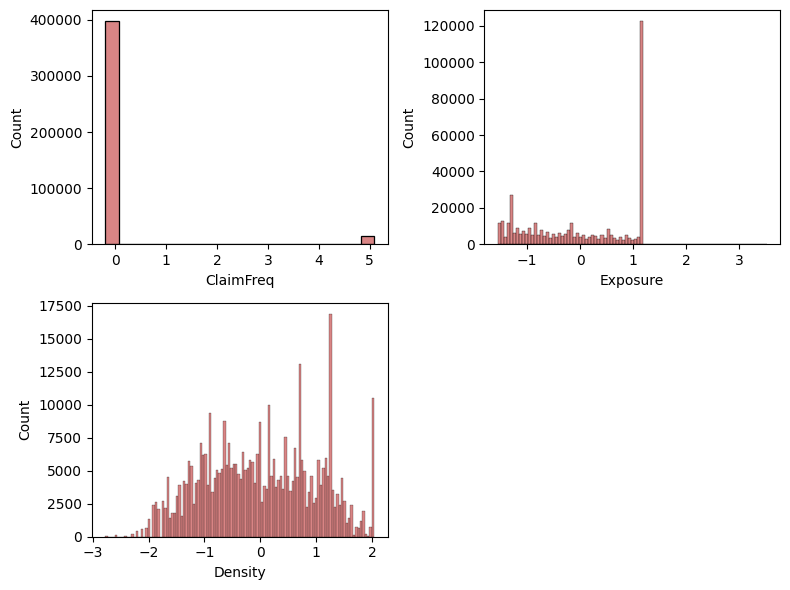

In [16]:
# distribution of data after scaling
import math
plt.figure(figsize=(8, 6))
# Calculate number of rows and columns required
con_features = len(X_copy.columns)
num_cols = 2  # Fixed number of columns
num_rows = math.ceil(con_features / num_cols)
for i in range(0,len(X_copy.columns)):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(X_copy[X_copy.columns[i]], color='indianred')
    plt.xlabel(X_copy.columns[i])
    plt.tight_layout()

In [17]:
X_copy.skew(axis=0, skipna=True)

ClaimFreq    4.887274
Exposure    -0.093464
Density      0.035764
dtype: float64

In [18]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [19]:
num_features

['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'ClaimFreq']

In [20]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413169 entries, 0 to 413168
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ClaimNb      413169 non-null  int64  
 1   Exposure     413169 non-null  float64
 2   Power        413169 non-null  object 
 3   CarAge       413169 non-null  int64  
 4   DriverAge    413169 non-null  int64  
 5   Brand        413169 non-null  object 
 6   Gas          413169 non-null  object 
 7   Region       413169 non-null  object 
 8   Density      413169 non-null  int64  
 9   ClaimAmount  413169 non-null  float64
 10  ClaimFreq    413169 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 34.7+ MB


In [21]:

oh_columns = ['Power','Brand','Gas','Region']
transform_columns= ['ClaimFreq','Density','Exposure']

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        #("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [22]:
X = preprocessor.fit_transform(X)

In [23]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.04746781,
        -0.39971827, -0.05512461],
       [ 0.        ,  0.        ,  0.        , ...,  0.04746781,
        -0.39971827, -0.05512461],
       [ 0.        ,  0.        ,  1.        , ..., -0.51087548,
         0.21310575, -0.05512461],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.25684654,
         0.70658926, -0.05512461],
       [ 1.        ,  0.        ,  0.        , ..., -0.30149675,
         1.64665755, -0.05512461],
       [ 0.        ,  0.        ,  0.        , ..., -1.13901168,
        -0.40202134, -0.05512461]])

In [24]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((330535, 40), (82634, 40))

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor

In [30]:
def evaluate_clf(true, predicted):
    
    mae = mean_absolute_error(true, predicted) # Calculate F1-score
    mse = mean_squared_error(true, predicted) # Calculate Precision

    return mae,mse

In [27]:
models = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
 
    "Linear Regression": LinearRegression(),

    "XGBClassifier": XGBRFRegressor(), 
     "CatBoosting Classifier": CatBoostRegressor()
 

}

In [33]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    mae_list = []
    
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        mae_train,mse_train=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        mae_test,mse_test=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
       
        print('- MAE: {:.4f}'.format(mae_train)) 
        print('- MSE: {:.4f}'.format(mse_train))


        print('----------------------------------')

        print('Model performance for Test set')
        
        
        print('- MAE: {:.4f}'.format(mae_test))
        mae_list.append(mae_test)
        print('- MSE: {:.4f}'.format(mse_test))
      
        
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, mae_list)), columns=['Model Name', 'MAE']).sort_values(by=['MAE'], ascending=True)
        
    return report

In [34]:
base_model_report =evaluate_models(X=X, y=y, models=models)
base_model_report

Random Forest
Model performance for Training set
- MAE: 39.1719
- MSE: 4330831.5858
----------------------------------
Model performance for Test set
- MAE: 107.2513
- MSE: 10885753.8920


Decision Tree
Model performance for Training set
- MAE: 0.0062
- MSE: 2.3281
----------------------------------
Model performance for Test set
- MAE: 106.1664
- MSE: 7560968.3217


Linear Regression
Model performance for Training set
- MAE: 121.4925
- MSE: 21021474.7797
----------------------------------
Model performance for Test set
- MAE: 115.5900
- MSE: 2742617.3482


XGBClassifier
Model performance for Training set
- MAE: 66.0650
- MSE: 3237035.6553
----------------------------------
Model performance for Test set
- MAE: 91.7223
- MSE: 12627285.8088


Learning rate set to 0.10238
0:	learn: 4550.8655153	total: 49.8ms	remaining: 49.8s
1:	learn: 4493.9869350	total: 79.6ms	remaining: 39.7s
2:	learn: 4425.8347617	total: 113ms	remaining: 37.7s
3:	learn: 4360.2632899	total: 153ms	remaining: 38s
4:	lear

,Model Name,MAE
3,XGBClassifier,91.722285
4,CatBoosting Classifier,105.503936
1,Decision Tree,106.166372
0,Random Forest,107.251262
2,Linear Regression,115.590039
